In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas import to_datetime
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pmdarima as pm
from pmdarima.model_selection import train_test_split


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [5]:
# 포트폴리오 관련 library import

import cvxopt as opt # python version 3.6-3.10 가능
from cvxopt import solvers
from pypfopt.efficient_frontier import EfficientFrontier # 정확하게는 모르겠는데 3.7은 사용가능
from pypfopt import risk_models
from pypfopt import expected_returns

In [6]:
df = pd.read_csv("C:/Users/User/github/Quant/data/kospi_category.csv", encoding='cp949')
start_date = '2004-01'
end_date = '2020-03'
 
df['time'] = pd.date_range(start_date,end_date,freq='m')
df.drop('date',axis=1, inplace=True)
df.set_index('time', inplace=True) 

In [7]:
# train 데이터와 validation 데이터 나누기.
X_train = df[df.index < '2019-01-01']
X_valid = df[df.index >= '2019-01-01']

# 각 데이터의 사이즈 확인하기
print('X_train Shape', X_train.shape)
print('X_Valid Shape', X_valid.shape)

X_train Shape (180, 22)
X_Valid Shape (14, 22)


  5%|▍         | 1/22 [00:05<01:57,  5.60s/it]

제조업 The MSE of auto-arima is: 69869.70982860656


  9%|▉         | 2/22 [00:14<02:34,  7.75s/it]

음식료품 The MSE of auto-arima is: 27358.963728057242


 14%|█▎        | 3/22 [00:42<05:20, 16.89s/it]

섬유의복 The MSE of auto-arima is: 340.46260770421975


 18%|█▊        | 4/22 [01:03<05:34, 18.56s/it]

종이목재 The MSE of auto-arima is: 382.8069225133988


 23%|██▎       | 5/22 [01:35<06:37, 23.40s/it]

화학 The MSE of auto-arima is: 52369.13938800721


 27%|██▋       | 6/22 [01:40<04:34, 17.15s/it]

의약품 The MSE of auto-arima is: 747592.3807111912


 32%|███▏      | 7/22 [01:46<03:19, 13.29s/it]

비금속광물 The MSE of auto-arima is: 6243.490142857144


 36%|███▋      | 8/22 [01:51<02:32, 10.87s/it]

철강금속 The MSE of auto-arima is: 50520.8865357144


 41%|████      | 9/22 [02:05<02:32, 11.77s/it]

기계 The MSE of auto-arima is: 2129.575508596078


 45%|████▌     | 10/22 [02:21<02:36, 13.06s/it]

전기전자 The MSE of auto-arima is: 1477476.87927399


 50%|█████     | 11/22 [02:33<02:20, 12.78s/it]

의료정밀 The MSE of auto-arima is: 62943.14033320832


 55%|█████▍    | 12/22 [02:39<01:45, 10.59s/it]

운수장비 The MSE of auto-arima is: 9970.688257142854


 59%|█████▉    | 13/22 [02:45<01:22,  9.18s/it]

유통업 The MSE of auto-arima is: 377.6617142857147


 64%|██████▎   | 14/22 [03:05<01:39, 12.41s/it]

전기가스업 The MSE of auto-arima is: 4817.700157436165


 68%|██████▊   | 15/22 [03:08<01:08,  9.72s/it]

건설업 The MSE of auto-arima is: 46.83447857142858


 73%|███████▎  | 16/22 [03:13<00:49,  8.22s/it]

운수창고업 The MSE of auto-arima is: 5325.152799999994


 77%|███████▋  | 17/22 [03:20<00:39,  7.85s/it]

통신업 The MSE of auto-arima is: 147.387692857143


 82%|████████▏ | 18/22 [03:30<00:33,  8.46s/it]

금융업 The MSE of auto-arima is: 446.9439358912327


 86%|████████▋ | 19/22 [03:37<00:24,  8.24s/it]

은행 The MSE of auto-arima is: 216.82689653920417


 91%|█████████ | 20/22 [03:47<00:17,  8.59s/it]

증권 The MSE of auto-arima is: 9795.285551624653


 95%|█████████▌| 21/22 [04:02<00:10, 10.60s/it]

보험 The MSE of auto-arima is: 837588.5221267983


100%|██████████| 22/22 [04:08<00:00, 11.29s/it]

서비스업 The MSE of auto-arima is: 1226.7039571428556


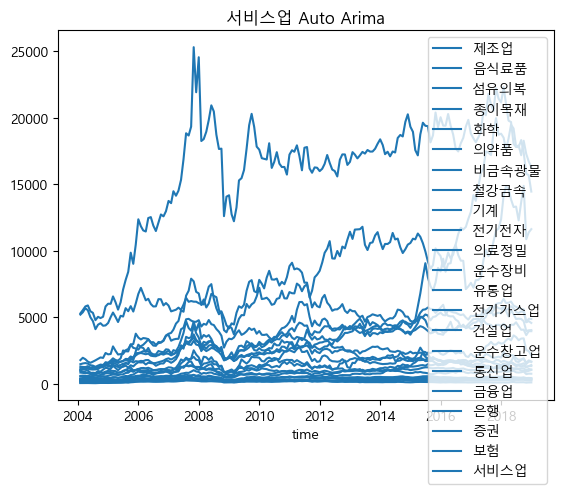

In [94]:
# Moving Window 적용
# Auto-ARIMA 돌리기 - 계측값이 일별이면 m=1, 월별이면 m=12, 주별이면 m=52, 
# 계절성이 있는 데이터면 seasonal=True 로 바꿔야함. 알아서 d 값을 찾아줌
arima_result = []
arima_result_2 = []
arima_result_3 = []
arima_val = []
for i in tqdm(range(len(df.columns))):
    predictions = list()
    history = [x for x in X_train.iloc[:,i]]
    for t in range(len(X_valid)):
        model = pm.auto_arima(y = history)
        output = model.predict()
        yhat = output[0]
        predictions.append(yhat)
        obs = X_valid.iloc[:,i][t]
        history.append(obs)
    
    predictions = pd.Series(predictions, index = X_valid.index)

    #hart = sns.lineplot(data = pd.DataFrame(X_train.iloc[:,i]))
    #chart.set_title(df.columns[i]+' Auto Arima')

    # plt.plot(X_train.iloc[:,i], color='blue')
    # plt.plot(predictions, color = 'red')
    # plt.plot(X_valid.iloc[:,i], color = 'blue')
    # plt.title(df.columns[i])
    # plt.legend()
    # plt.savefig("C:/Users/User/github/Quant/data/"+df.columns[i]+" moving_window.png")
    print(df.columns[i]+' The MSE of auto-arima is:', mean_squared_error(X_valid.iloc[:,i].values, predictions))
    arima_result.append( mean_squared_error(X_valid.iloc[:,i].values, predictions))
    arima_result_2.append(model.summary())
    arima_result_3.append(r2_score(X_valid.iloc[:,i], predictions))
    arima_val.append(predictions)
    # plt.clf()
    

In [95]:
predict = pd.DataFrame(arima_val).T

---
#### 미래 예측 완료
#### train 구간만 사용한 포트폴리오와 예측 구간까지 사용한 포트폴리오의 차이를 확인할 것임
#### train 구간이 움직일때 포트폴리오를 다시 최적화 할것임.
#### 즉 한달 주기로 포트폴리오를 다시 구성한다고 생각하면 될것.
#### 수수료는 없다고 가정
#### 처음 주식을 구매하고 주식을 전부 판매하고 다시 주식을 구매하는 것으로 돈을 계속 계산할 것임

In [98]:
weights = np.ones(22) # 초기에 가중치를 1로 설정
weights = weights/22 # 이후 동일하게 1/22으로 나눠서 설정 (가중치 합은 항상 1)

returns=X_train.pct_change() # 단순 수익률 계산 => (다음날 값 +- 기준일 값)/기준일 값 으로 수익률 나옵니다.

cov_matrix_annual=returns.cov()*12 # 데이터 기준이 DAY가 아니라 MONTH이므로 12를 곱해 연간 수익률로 계산

port_variance=np.dot(weights.T, np.dot(cov_matrix_annual, weights)) # 포트폴리오 분산의 기대값 = WT * (공분산{= 시그마}) * W를 코드로 옆처럼 나타냄

port_volatility=np.sqrt(port_variance) # 포트폴리오 변동성의 기대값 = SQRT(WT * 공분산(=시그마) * W) // 그냥 표준편차 = 변동성

portfolioSimpleAnnualReturn=np.sum(returns.mean()*weights)*12 # 연간 수익률 계산 DAY가 아니라 MONTH기준이므로 12곱하면 됨

In [99]:
percent_var=str(round(port_variance,2)*100)+'%'
percent_vol=str(round(port_volatility,2)*100)+'%'
percent_ret=str(round(portfolioSimpleAnnualReturn,2)*100)+'%'

In [100]:
print('Expected Annual Return :'+ percent_ret )
print('Annual Volatility/risk :'+ percent_vol )
print('Annual Variance :'+ percent_var )

Expected Annual Return :9.0%
Annual Volatility/risk :19.0%
Annual Variance :3.0%


In [101]:
# Portfolio optimization

# Calculate the expexted returns and annualised sample covariance matrix of the asset returns
mu=expected_returns.mean_historical_return(X_train, frequency=12) # 앞과 동일하게 data가 month기준
S=risk_models.sample_cov(X_train, frequency= 12) # 앞과 동일하게 data가 month기준

# Optimize the max sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe() #Maximize the Sharpe ratio, and get the raw weights
cleaned_weights = ef.clean_weights() 
print(cleaned_weights) #Note the weights may have some rounding error, meaning they may not add up exactly to 1 but should be close
ef.portfolio_performance(verbose=True)

OrderedDict([('제조업', 0.0), ('음식료품', 0.0), ('섬유의복', 0.0), ('종이목재', 0.0), ('화학', 0.26938), ('의약품', 0.55999), ('비금속광물', 0.0), ('철강금속', 0.0), ('기계', 0.0), ('전기전자', 0.16066), ('의료정밀', 0.00997), ('운수장비', 0.0), ('유통업', 0.0), ('전기가스업', 0.0), ('건설업', 0.0), ('운수창고업', 0.0), ('통신업', 0.0), ('금융업', 0.0), ('은행', 0.0), ('증권', 0.0), ('보험', 0.0), ('서비스업', 0.0)])
Expected annual return: 13.5%
Annual volatility: 21.6%
Sharpe Ratio: 0.53


(0.13492968879251077, 0.2161293716058797, 0.5317633967959224)

In [102]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(X_train)
weights = cleaned_weights 

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=1000000000000)
allocation, leftover = da.lp_portfolio()

print("Discrete allocation:", allocation) # 해당주를 얼마나 구입하는가
print("Funds remaining: ${:.2f}".format(leftover)) # 예상 수익률

Discrete allocation: {'화학': 55258229, '의약품': 48164181, '전기전자': 11120633, '의료정밀': 4672324}
Funds remaining: $902.32


In [159]:
predict.columns = np.array(X_train.columns)

In [164]:
total = pd.concat([ X_train, predict])

In [166]:
print(len(X_train))
print(len(total))

180
194


In [ ]:
## 동일 가중치 포트폴리오를 계속 

weights = np.ones(22) 
weights = weights/22 
returns=X_train.pct_change() 
cov_matrix_annual=returns.cov()*12
port_variance=np.dot(weights.T, np.dot(cov_matrix_annual, weights)) 
port_volatility=np.sqrt(port_variance) 
portfolioSimpleAnnualReturn=np.sum(returns.mean()*weights)*12 

In [203]:
pd.DataFrame(predict.iloc[0,:]).T

,제조업,음식료품,섬유의복,종이목재,화학,의약품,비금속광물,철강금속,기계,전기전자,...,유통업,전기가스업,건설업,운수창고업,통신업,금융업,은행,증권,보험,서비스업
2019-01-31,4579.62,3907.933949,247.084996,357.66,4782.24948,11626.69,1661.05,4043.12,738.343602,14107.500651,...,393.5,1050.6,112.6,1341.29,397.99,434.405401,298.840542,1689.914681,16366.798971,1080.0


In [204]:
X_tarin_input = pd.concat([X_train, pd.DataFrame(predict.iloc[0,:]).T])

In [276]:
a = 100000000
solution = []
money = []
X_tarin_input = pd.concat([X_train, pd.DataFrame(predict.iloc[0,:]).T])
for i in range(0,13):
    latest_prices = get_latest_prices(pd.concat([X_train, pd.DataFrame(predict.iloc[i+1,:]).T]))
    weights = cleaned_weights 

    da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=a)
    solution.append(da.lp_portfolio())
    money.append(a) 
    a += pd.DataFrame(solution).iloc[i,1]


In [274]:
(pd.DataFrame(money)-100000000)*1200

,0
0,0.000000e+00
1,1.772852e+04
2,2.730724e+06
3,2.805431e+06
4,2.817150e+06
5,5.465526e+06
6,5.552124e+06
7,5.975237e+06
8,7.836805e+06
9,8.197600e+06


Text(0.5, 1.0, '포트폴리오 업데이트 횟수별 자산 변화')

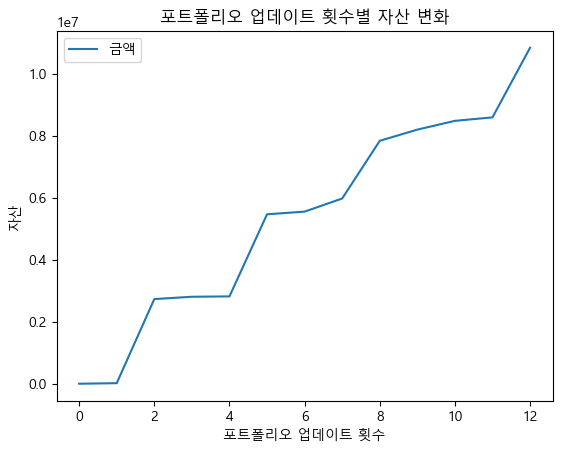

In [271]:
plt.plot((pd.DataFrame(money)-100000000)*1200, label = '금액')
plt.xlabel('포트폴리오 업데이트 횟수')
plt.ylabel('자산')
plt.legend()
plt.title('포트폴리오 업데이트 횟수별 자산 변화')

In [312]:
solution[0][0].keys()


dict_values([4, 5215, 4733, 929, 383, 1])

In [321]:
solution[1][0].values()

dict_values([4981, 4880, 960, 399])

In [320]:
pd.DataFrame.from_dict(data = solution[0][0], orient='index', dtype='int').T

,섬유의복,화학,의약품,전기전자,의료정밀,은행
0,4,5215,4733,929,383,1
